In [1]:
import os
import numpy as np
import pandas as pd
import shutil
import cv2
import random
import matplotlib.pyplot as plt
import copy
import wandb

In [2]:
bs=' ' # blank-space
class_id=0 # id for face
newline='\n' # new line character
extension='.txt' # extension for text file

In [3]:
curr_path=os.getcwd()
imgtrainpath = os.path.join(curr_path,'images','train')
imgvalpath=os.path.join(curr_path,'images','validation')
imgtestpath=os.path.join(curr_path,'images','test')

labeltrainpath=os.path.join(curr_path,'labels','train')
labelvalpath=os.path.join(curr_path,'labels','validation')
labeltestpath=os.path.join(curr_path,'labels','test')

In [4]:
data_path=r'/content/Human_Faces'
labels_path = os.path.join(curr_path, 'face_labels')

In [5]:
#face label namni directory banai
os.makedirs(labels_path)

In [6]:
os.listdir(data_path)

['faces.csv', '.ipynb_checkpoints', 'images']

In [7]:
#images ane raw annotations no path che
img_path=os.path.join(data_path, 'images')
raw_annotations_path=os.path.join(data_path, 'faces.csv')

In [8]:
#badu images no data list ma nakhyu
face_list=os.listdir(img_path)

In [9]:
#just for checking
face_list[:5]

['00000886.jpg',
 '00001881.jpg',
 '00001373.jpg',
 '00002556.jpg',
 '00003390.jpg']

In [10]:
#to check for the length of data
data_len=len(face_list)
data_len

2204

In [11]:
random.shuffle(face_list)
# Checking if they are shuffled
face_list[:5]

['00002264.jpg',
 '00001171.jpg',
 '00003498.jpg',
 '00001870.jpg',
 '00003154.jpg']

In [12]:
train_split=0.8
val_split=0.1
test_split=0.1

imgtrain_list=face_list[:int(data_len*train_split)] 
imgval_list=face_list[int(data_len*train_split):int(data_len*(train_split+val_split))]
imgtest_list=face_list[int(data_len*(train_split+val_split)):]

In [13]:
imgtest_list[:5]

['00003146.jpg',
 '00001352.jpg',
 '00000072.jpg',
 '00001885.jpg',
 '00001548.jpg']

In [14]:
# Checking the size of train, validation and test dataset
len(imgtrain_list), len(imgval_list), len(imgtest_list)

(1763, 220, 221)

In [15]:
def change_extension(file):
    basename=os.path.splitext(file)[0]
    filename=basename+extension
    return filename

In [16]:
labeltrain_list = list(map(change_extension, imgtrain_list))
labelval_list = list(map(change_extension, imgval_list))
labeltest_list = list(map(change_extension, imgtest_list))

In [17]:
len(labeltrain_list), len(labelval_list), len(labeltest_list)
labeltest_list[:5]

['00003146.txt',
 '00001352.txt',
 '00000072.txt',
 '00001885.txt',
 '00001548.txt']

In [18]:
raw_annotations=pd.read_csv(raw_annotations_path)
raw_annotations

image_name  width  height   x0   y0    x1   y1
0     00001722.jpg   1333    2000  490  320   687  664
1     00001044.jpg   2000    1333  791  119  1200  436
2     00001050.jpg    667    1000  304  155   407  331
3     00001736.jpg    626     417  147   14   519  303
4     00003121.jpg    626     418  462   60   599  166
...            ...    ...     ...  ...  ...   ...  ...
3345  00002232.jpg    620     349    4   36   186  158
3346  00002232.jpg    620     349  122  103   344  248
3347  00002232.jpg    620     349  258  118   541  303
3348  00002232.jpg    620     349  215   11   362  108
3349  00002232.jpg    620     349  330    1   487   81

[3350 rows x 7 columns]

In [19]:
raw_annotations['x_centre']=0.5*(raw_annotations['x0']+raw_annotations['x1'])
raw_annotations['y_centre']=0.5*(raw_annotations['y0']+raw_annotations['y1'])
raw_annotations['bb_width']=raw_annotations['x1']-raw_annotations['x0']
raw_annotations['bb_height']=raw_annotations['y1']-raw_annotations['y0']
raw_annotations

image_name  width  height   x0   y0    x1   y1  x_centre  y_centre  \
0     00001722.jpg   1333    2000  490  320   687  664     588.5     492.0   
1     00001044.jpg   2000    1333  791  119  1200  436     995.5     277.5   
2     00001050.jpg    667    1000  304  155   407  331     355.5     243.0   
3     00001736.jpg    626     417  147   14   519  303     333.0     158.5   
4     00003121.jpg    626     418  462   60   599  166     530.5     113.0   
...            ...    ...     ...  ...  ...   ...  ...       ...       ...   
3345  00002232.jpg    620     349    4   36   186  158      95.0      97.0   
3346  00002232.jpg    620     349  122  103   344  248     233.0     175.5   
3347  00002232.jpg    620     349  258  118   541  303     399.5     210.5   
3348  00002232.jpg    620     349  215   11   362  108     288.5      59.5   
3349  00002232.jpg    620     349  330    1   487   81     408.5      41.0   

      bb_width  bb_height  
0          197        344  
1          409        317  
2          103        176  
3          372        289  
4          137        106  
...        ...        ...  
3345       182        122  
3346       222        145  
3347       283        185  
3348       147         97  
3349       157         80  

[3350 rows x 11 columns]

In [20]:
raw_annotations['xcentre_scaled']=raw_annotations['x_centre']/raw_annotations['width']
raw_annotations['ycentre_scaled']=raw_annotations['y_centre']/raw_annotations['height']
raw_annotations['width_scaled']=raw_annotations['bb_width']/raw_annotations['width']
raw_annotations['height_scaled']=raw_annotations['bb_height']/raw_annotations['height']
raw_annotations

image_name  width  height   x0   y0    x1   y1  x_centre  y_centre  \
0     00001722.jpg   1333    2000  490  320   687  664     588.5     492.0   
1     00001044.jpg   2000    1333  791  119  1200  436     995.5     277.5   
2     00001050.jpg    667    1000  304  155   407  331     355.5     243.0   
3     00001736.jpg    626     417  147   14   519  303     333.0     158.5   
4     00003121.jpg    626     418  462   60   599  166     530.5     113.0   
...            ...    ...     ...  ...  ...   ...  ...       ...       ...   
3345  00002232.jpg    620     349    4   36   186  158      95.0      97.0   
3346  00002232.jpg    620     349  122  103   344  248     233.0     175.5   
3347  00002232.jpg    620     349  258  118   541  303     399.5     210.5   
3348  00002232.jpg    620     349  215   11   362  108     288.5      59.5   
3349  00002232.jpg    620     349  330    1   487   81     408.5      41.0   

      bb_width  bb_height  xcentre_scaled  ycentre_scaled  width_scaled  \
0          197        344        0.441485        0.246000      0.147787   
1          409        317        0.497750        0.208177      0.204500   
2          103        176        0.532984        0.243000      0.154423   
3          372        289        0.531949        0.380096      0.594249   
4          137        106        0.847444        0.270335      0.218850   
...        ...        ...             ...             ...           ...   
3345       182        122        0.153226        0.277937      0.293548   
3346       222        145        0.375806        0.502865      0.358065   
3347       283        185        0.644355        0.603152      0.456452   
3348       147         97        0.465323        0.170487      0.237097   
3349       157         80        0.658871        0.117479      0.253226   

      height_scaled  
0          0.172000  
1          0.237809  
2          0.176000  
3          0.693046  
4          0.253589  
...             ...  
3345       0.349570  
3346       0.415473  
3347       0.530086  
3348       0.277937  
3349       0.229226  

[3350 rows x 15 columns]

In [21]:
len(raw_annotations['image_name'].unique())

2204

In [22]:
imgs=raw_annotations.groupby('image_name')

In [23]:
for image in imgs:
    img_df=imgs.get_group(image[0])
    basename=os.path.splitext(image[0])[0]
    txt_file=basename+extension
    filepath=os.path.join(labels_path, txt_file)
    lines=[]
    i=1
    for index,row in img_df.iterrows():
        if i!=len(img_df): # condition ke jo ek thi vadhare object hoy image ma to next line avse nekar else ma ek aj row banse
            line=str(class_id)+bs+str(row['xcentre_scaled'])+bs+str(row['ycentre_scaled'])+bs+str(row['width_scaled'])+bs+str(row['height_scaled'])+newline
            lines.append(line)
        else:
            line=str(class_id)+bs+str(row['xcentre_scaled'])+bs+str(row['ycentre_scaled'])+bs+str(row['width_scaled'])+bs+ str(row['height_scaled'])
            lines.append(line)
        i=i+1
    with open(filepath, 'w') as file:
        file.writelines(lines)

In [24]:
os.listdir(labels_path)[:5]

random_file=os.path.join(labels_path, os.listdir(labels_path)[4])
with open (random_file, 'r') as f:
    content=f.read()
content

'0 0.487060546875 0.295970695970696 0.20458984375 0.23736263736263735\n0 0.693115234375 0.4582417582417582 0.12451171875 0.1443223443223443'

In [25]:
def_size=640
len(os.listdir(labels_path))

2204

In [26]:
def move_files(data_list, source_path, destination_path):
    i=0
    for file in data_list:
        filepath=os.path.join(source_path, file)
        dest_path=os.path.join(data_path, destination_path)
        if not os.path.isdir(dest_path):
            os.makedirs(dest_path)
        shutil.move(filepath, dest_path)
        i=i+1
    print("Number of files transferred:", i)

In [27]:
def move_images(data_list, source_path, destination_path):
    i=0
    for file in data_list:
        filepath=os.path.join(source_path, file)
        dest_path=os.path.join(data_path, destination_path)

        if not os.path.isdir(dest_path):
            os.makedirs(dest_path)
        finalimage_path=os.path.join(dest_path, file)
        img_resized=cv2.resize(cv2.imread(filepath), (def_size, def_size))
        cv2.imwrite(finalimage_path, img_resized)
        i=i+1
    print("Number of files transferred:", i)

In [28]:
move_images(imgtrain_list, img_path, imgtrainpath)

Number of files transferred: 1763


In [29]:
move_images(imgval_list, img_path, imgvalpath)
move_images(imgtest_list, img_path, imgtestpath)

Number of files transferred: 220
Number of files transferred: 221


In [30]:
move_files(labeltrain_list, labels_path, labeltrainpath)
move_files(labelval_list, labels_path, labelvalpath)
move_files(labeltest_list, labels_path, labeltestpath)

Number of files transferred: 1763
Number of files transferred: 220
Number of files transferred: 221


In [31]:
len(os.listdir(labels_path))
shutil.rmtree(labels_path)

In [32]:
ln_1='# Train/val/test sets'+newline
ln_2='train: ' +"'"+imgtrainpath+"'"+newline
ln_3='val: ' +"'" + imgvalpath+"'"+newline
ln_4='test: ' +"'" + imgtestpath+"'"+newline
ln_5=newline
ln_6='# Classes'+newline
ln_7='names:'+newline
ln_8='  0: face'
config_lines=[ln_1, ln_2, ln_3, ln_4, ln_5, ln_6, ln_7, ln_8]


In [33]:
config_path=os.path.join(curr_path, 'config.yaml')
config_path

'/content/config.yaml'

In [34]:
with open(config_path, 'w') as f:
    f.writelines(config_lines)

In [35]:
def get_bbox_from_label(text_file_path):
    bbox_list=[]
    with open(text_file_path, "r") as file:
        for line in file:
            _,x_centre,y_centre,width,height=line.strip().split(" ")
            x1=(float(x_centre)+(float(width)/2))*def_size
            x0=(float(x_centre)-(float(width)/2))*def_size
            y1=(float(y_centre)+(float(height)/2))*def_size
            y0=(float(y_centre)-(float(height)/2))*def_size

            vertices=np.array([[int(x0), int(y0)], [int(x1), int(y0)],
                               [int(x1),int(y1)], [int(x0),int(y1)]])
#             vertices=vertices.reshape((-1,1,2))
            bbox_list.append(vertices)

    return tuple(bbox_list)

In [36]:
red=(255,0,0)

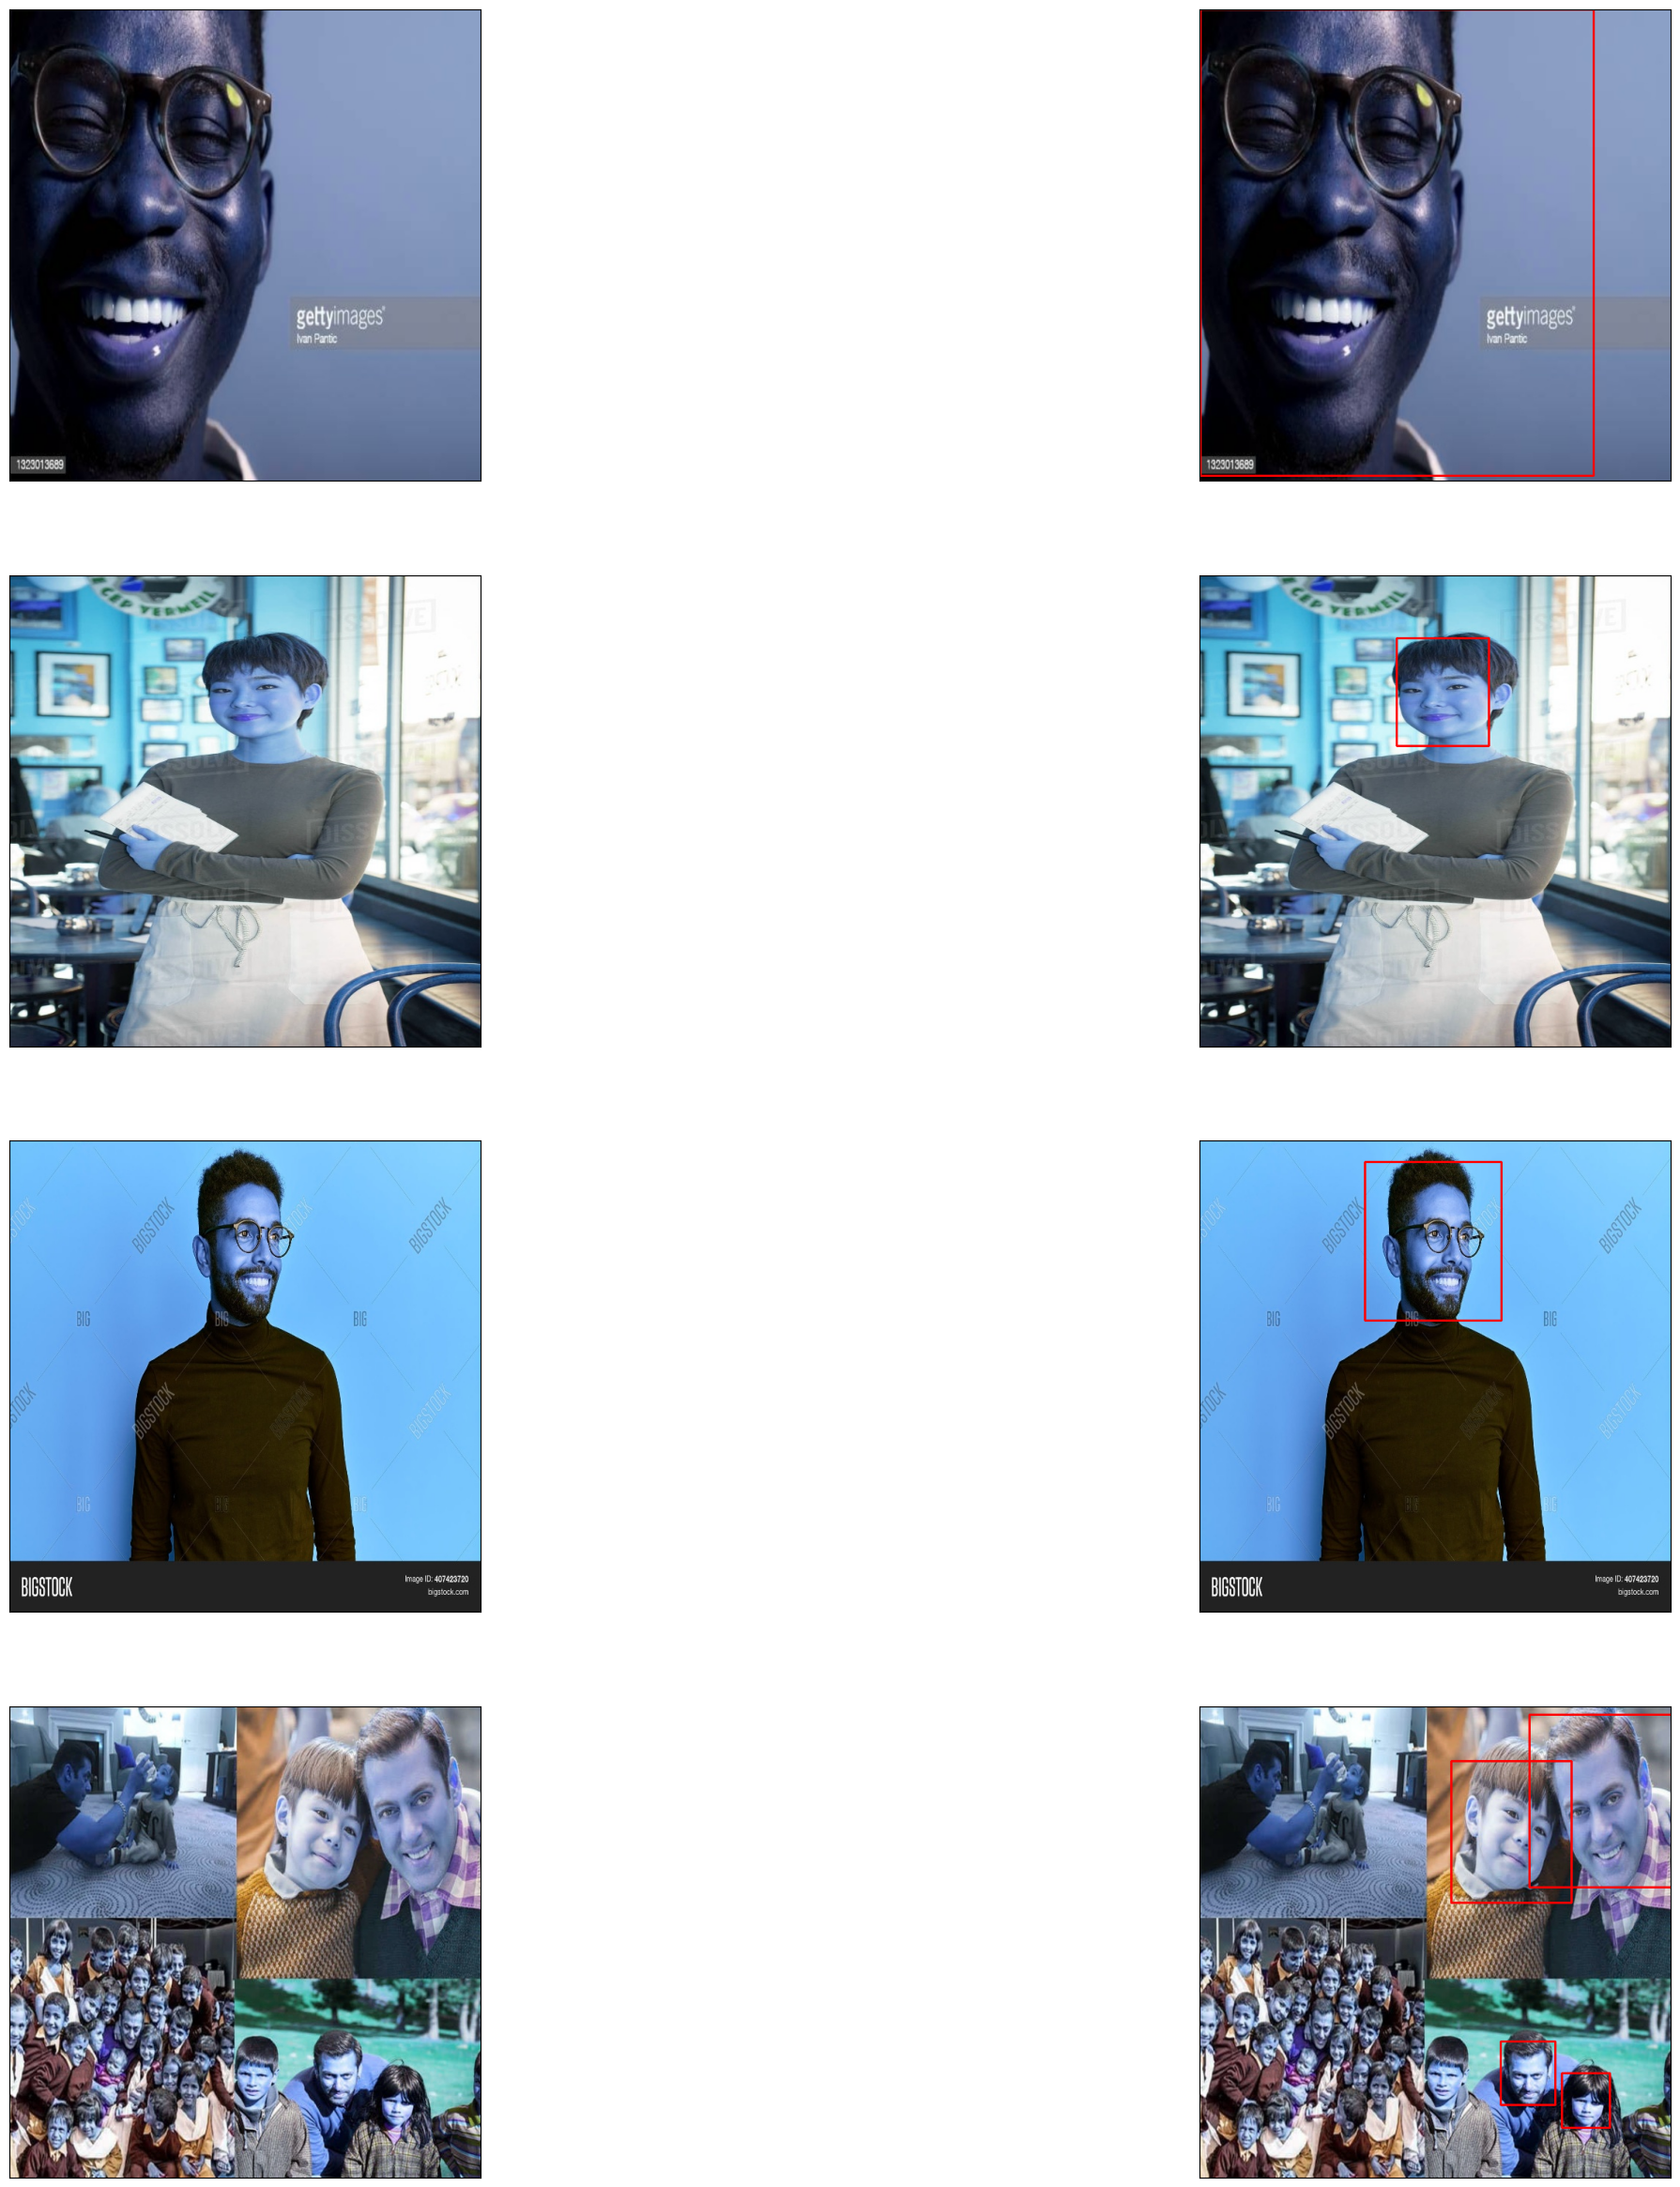

In [37]:
plt.figure(figsize=(30,30))
for i in range(1,8,2):
    k=random.randint(0, len(imgtrain_list)-1)
    img_path=os.path.join(imgtrainpath, imgtrain_list[k])
    label_path=os.path.join(labeltrainpath, labeltrain_list[k])
    bbox=get_bbox_from_label(label_path)
    image=cv2.imread(img_path)
    image_copy=copy.deepcopy(image)
    ax=plt.subplot(4, 2, i)
    plt.imshow(image) # displaying image
    plt.xticks([])
    plt.yticks([])
    cv2.drawContours(image_copy, bbox, -1, red, 2) # drawing bounding box on copy of image
    ax=plt.subplot(4, 2, i+1)
    plt.imshow(image_copy) # displaying image with bounding box
    plt.xticks([])
    plt.yticks([])

In [38]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 16.6 MB/s eta 0:00:00


In [41]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [42]:
model=YOLO('yolov8n.yaml').load('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 74.3MB/s]

Transferred 355/355 items from pretrained weights


In [44]:
results=model.train(data=config_path, epochs=4, resume=True, iou=0.5, conf=0.001)

Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/config.yaml, epochs=4, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=yolov8n.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=None, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

train: Scanning /content/labels/train.cache... 1763 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1763/1763 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/labels/validation.cache... 220 images, 0 backgrounds, 0 corrupt: 100%|██████████| 220/220 [00:00<?, ?it/s]

Plotting labels to runs/detect/train2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 4 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/4         0G      1.521      2.067      1.654          6        640: 100%|██████████| 111/111 [23:20<00:00, 12.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:05<00:00,  9.37s/it]

                   all        220        372      0.806      0.791      0.834      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/4         0G      1.329      1.424      1.503          4        640: 100%|██████████| 111/111 [23:29<00:00, 12.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:01<00:00,  8.77s/it]

                   all        220        372      0.844      0.876       0.91      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/4         0G      1.261      1.192      1.438          8        640: 100%|██████████| 111/111 [23:20<00:00, 12.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:02<00:00,  8.93s/it]

                   all        220        372      0.874      0.933       0.91      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/4         0G      1.172      1.019      1.376          4        640: 100%|██████████| 111/111 [23:12<00:00, 12.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:02<00:00,  8.94s/it]

                   all        220        372      0.869      0.981      0.966      0.671



4 epochs completed in 1.629 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:55<00:00,  7.95s/it]


                   all        220        372      0.869      0.981      0.966      0.671
Speed: 2.4ms preprocess, 236.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train2


In [46]:
def evaluate_map50(trainedmodel, data_path, dataset='val'):
    metrics=trainedmodel.val(data=data_path, split=dataset)
    map50=round(metrics.box.map50, 3)
    print("The mAP of model on {0} dataset is {1}".format(dataset,map50))
    return metrics, map50

In [47]:
# function for displaying plots created by YOLO
def display_curves(root_path):
    plt.figure(figsize=(50,50))

    #displaying p curve
    p_curve=cv2.imread(os.path.join(root_path,"P_curve.png"))
    ax=plt.subplot(5,1,1)
    print(p_curve)
    plt.imshow(p_curve)

    #displaying r curve
    r_curve=cv2.imread(os.path.join(root_path,"R_curve.png"))
    ax=plt.subplot(5,1,2)
    plt.imshow(r_curve)

    #displaying pr curve
    pr_curve=cv2.imread(os.path.join(root_path,"PR_curve.png"))
    ax=plt.subplot(5,1,3)
    plt.imshow(pr_curve)

    #displaying f1 curve
    f1_curve=cv2.imread(os.path.join(root_path,"F1_curve.png"))
    ax=plt.subplot(5,1,4)
    plt.imshow(f1_curve)

    #displaying confusion matrix
    confusion_matrix=cv2.imread(os.path.join(root_path,"confusion_matrix.png"))
    ax=plt.subplot(5,1,5)
    plt.imshow(confusion_matrix)


In [48]:
train_metrics, train_map50=evaluate_map50(model, config_path, dataset='train')


Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/labels/train.cache... 1763 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1763/1763 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [07:11<00:00,  3.89s/it]


                   all       1763       2650      0.898      0.946      0.964      0.684
Speed: 2.4ms preprocess, 233.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train22
The mAP of model on train dataset is 0.964


In [49]:
train_path=os.path.join(curr_path, 'runs', 'detect', 'train2') #val is a misnomer, it is actually measuring validation on training dataset

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


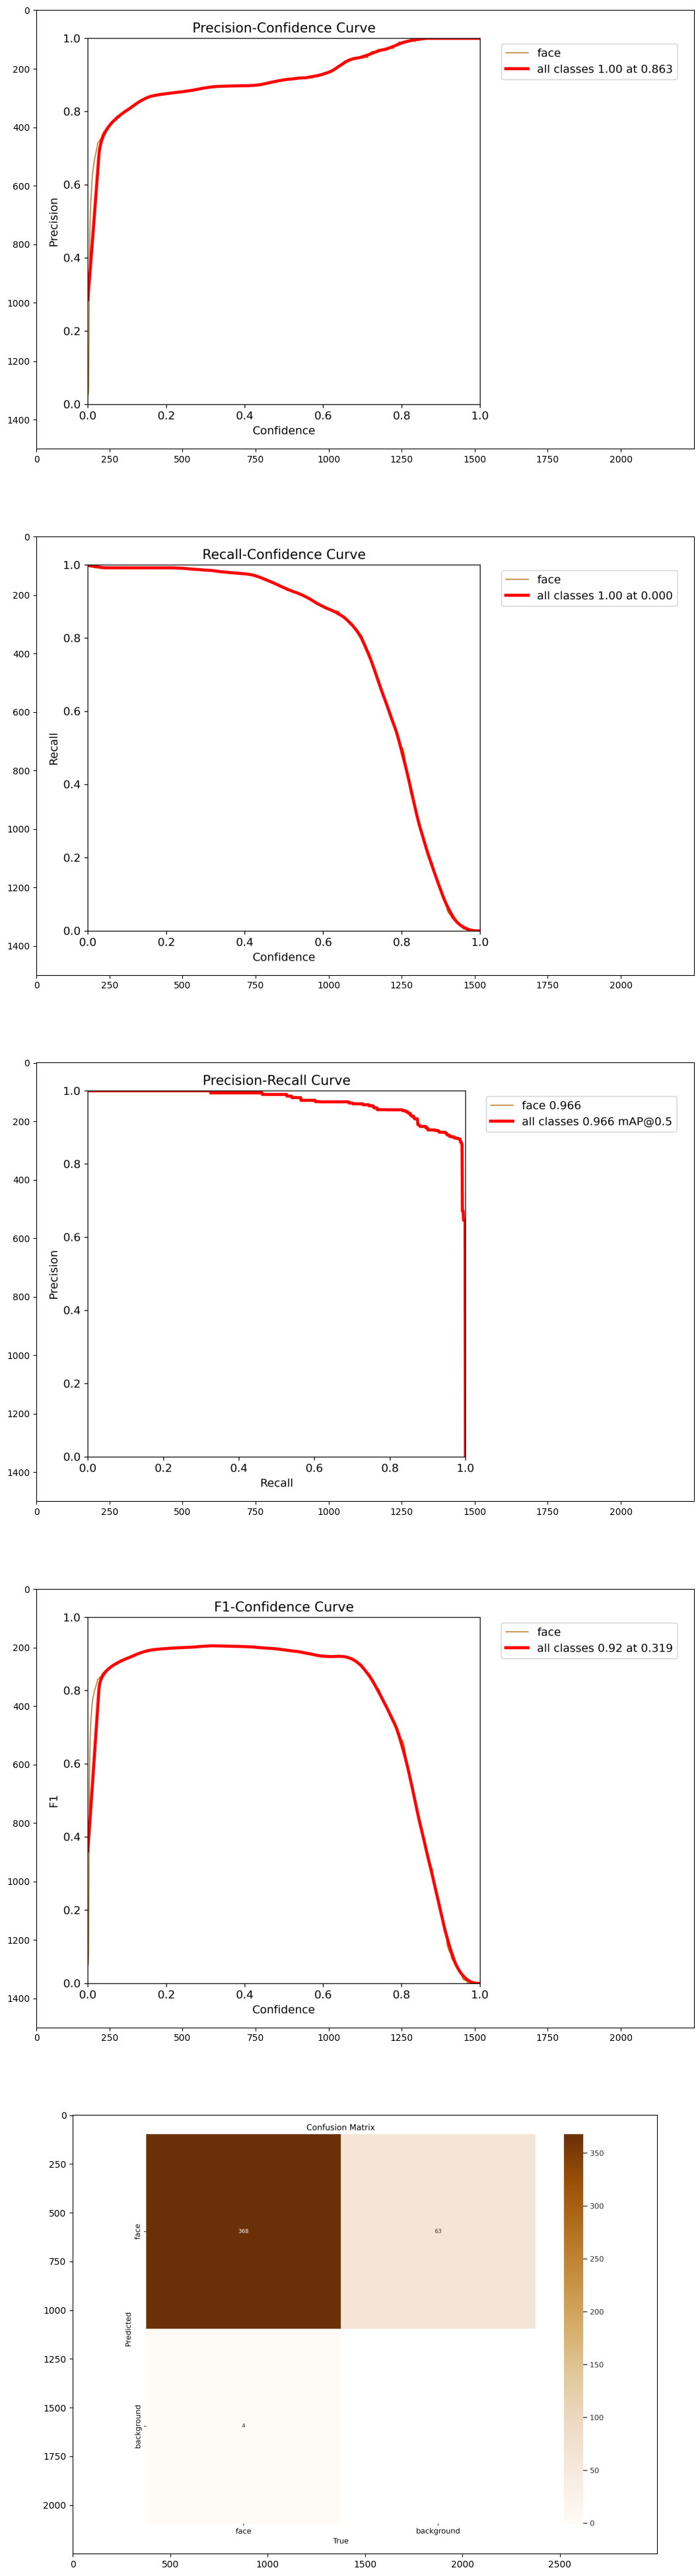

In [50]:
display_curves(train_path)

In [51]:
val_metrics, val_map50=evaluate_map50(model, config_path, dataset='val')

Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/labels/validation.cache... 220 images, 0 backgrounds, 0 corrupt: 100%|██████████| 220/220 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:54<00:00,  3.89s/it]


                   all        220        372      0.869      0.981      0.966      0.671
Speed: 2.8ms preprocess, 233.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train23
The mAP of model on val dataset is 0.966


In [53]:
test_metrics, test_map50=evaluate_map50(model, config_path, dataset='test')

Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/labels/test... 221 images, 0 backgrounds, 0 corrupt: 100%|██████████| 221/221 [00:00<00:00, 268.13it/s]

val: New cache created: /content/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:54<00:00,  3.92s/it]


                   all        221        328      0.877      0.915      0.951      0.673
Speed: 2.7ms preprocess, 235.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train24
The mAP of model on test dataset is 0.951


In [54]:
test_path=os.path.join(curr_path, 'runs', 'detect', 'train3') #val3 is a misnomer, it is actually measuring validation on test dataset


image 1/1 /content/images/test/00001431.jpg: 640x640 1 face, 197.8ms
Speed: 3.9ms preprocess, 197.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/images/test/00000363.jpg: 640x640 2 faces, 493.7ms
Speed: 3.2ms preprocess, 493.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/images/test/00002775.jpg: 640x640 1 face, 698.3ms
Speed: 14.5ms preprocess, 698.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/images/test/00001445.jpg: 640x640 1 face, 561.6ms
Speed: 7.3ms preprocess, 561.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


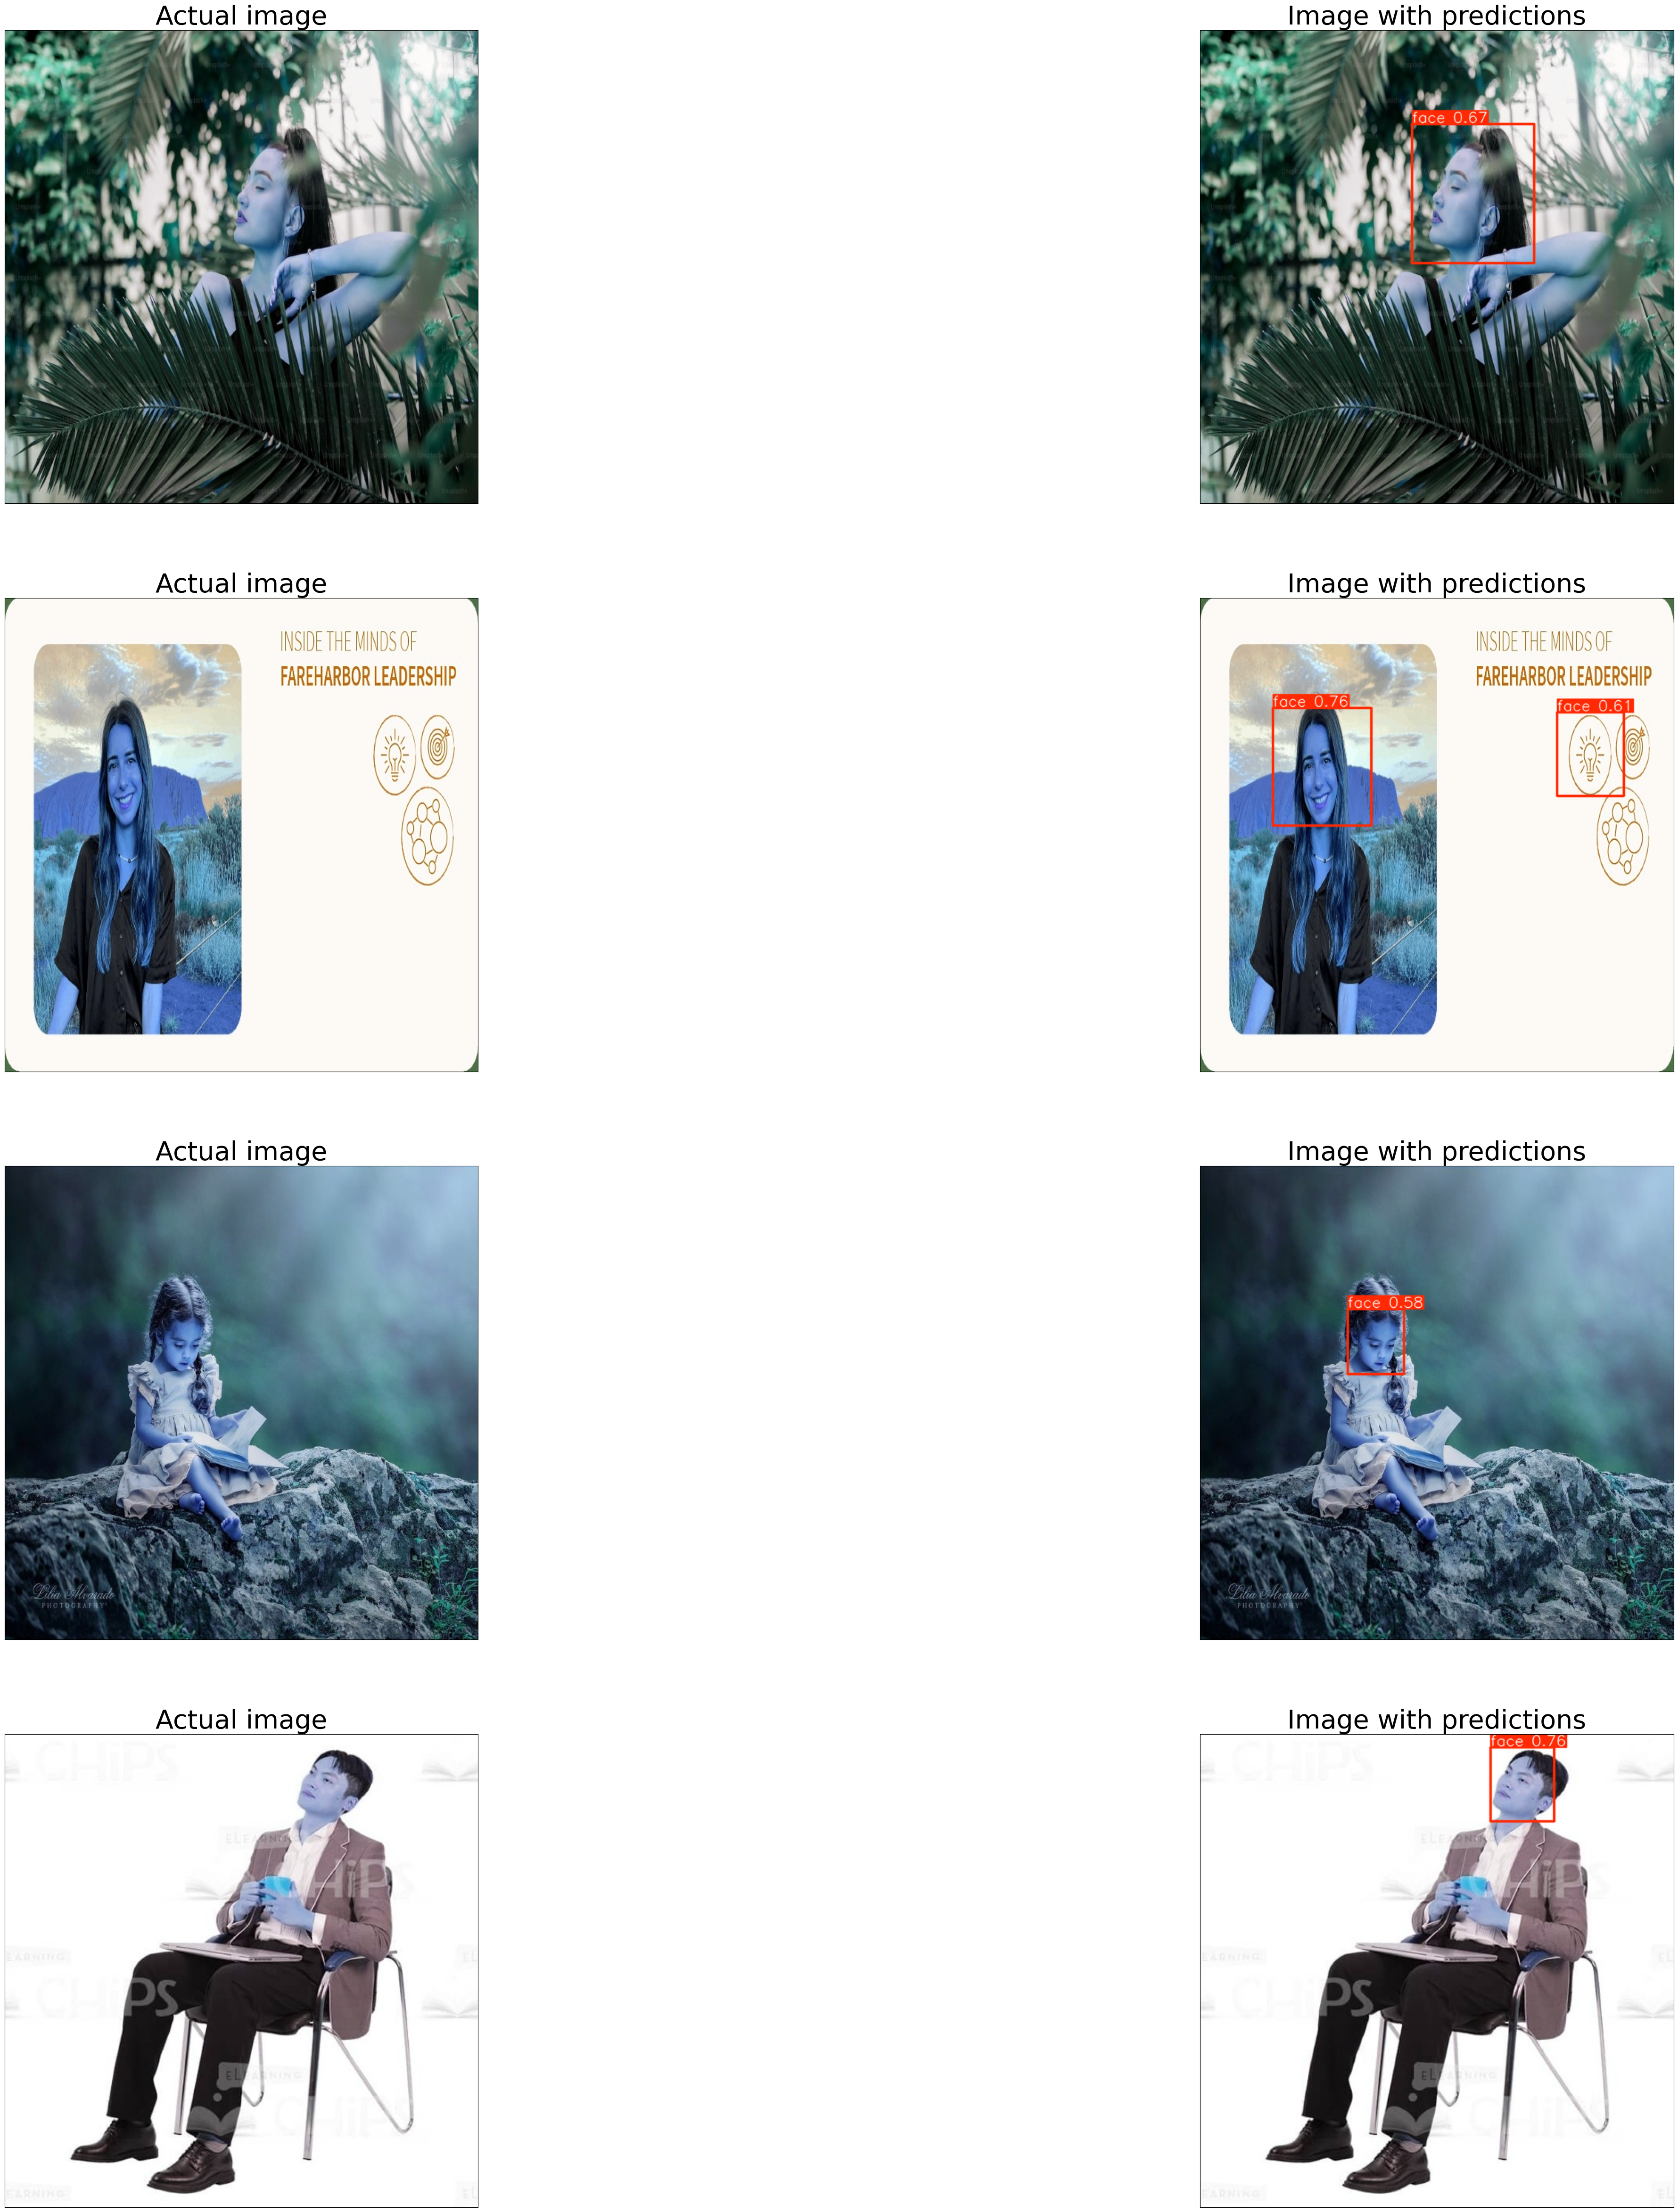

In [56]:
plt.figure(figsize=(60,60))
m=random.randint(0, 150) # Selecting random image number
for i in range(1,8,2):
    test_image=os.path.join(imgtestpath, os.listdir(imgtestpath)[m])
    ax=plt.subplot(4,2,i)

    # Display actual image
    plt.imshow(cv2.imread(test_image))
    plt.xticks([])
    plt.yticks([])
    plt.title("Actual image", fontsize = 40)

    # Predict
    res = model(test_image)
    res_plotted = res[0].plot()
    ax=plt.subplot(4,2,i+1)

    # Display image with predictions
    plt.imshow(res_plotted)
    plt.title("Image with predictions", fontsize = 40)
    plt.xticks([])
    plt.yticks([])
    m=m+1


In [57]:
model.save('best.pt')  # Saves the model to 'best.pt'


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
%cd /content/runs

/content/runs


In [60]:
!zip -r runs.zip /content/runs

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/train22/ (stored 0%)
  adding: content/runs/detect/train22/val_batch1_labels.jpg (deflated 7%)
  adding: content/runs/detect/train22/val_batch0_pred.jpg (deflated 8%)
  adding: content/runs/detect/train22/P_curve.png (deflated 19%)
  adding: content/runs/detect/train22/confusion_matrix.png (deflated 37%)
  adding: content/runs/detect/train22/F1_curve.png (deflated 18%)
  adding: content/runs/detect/train22/val_batch2_labels.jpg (deflated 8%)
  adding: content/runs/detect/train22/PR_curve.png (deflated 25%)
  adding: content/runs/detect/train22/confusion_matrix_normalized.png (deflated 38%)
  adding: content/runs/detect/train22/val_batch0_labels.jpg (deflated 8%)
  adding: content/runs/detect/train22/val_batch2_pred.jpg (deflated 8%)
  adding: content/runs/detect/train22/val_batch1_pred.jpg (deflated 7%)
  adding: content/runs/detect/train22/R_curve.png (deflated 18%)
  adding: c

In [61]:
from google.colab import files
files.download('runs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
%cd /content/labels

/content/labels


In [63]:
!zip -r labels.zip /content/labels

  adding: content/labels/ (stored 0%)
  adding: content/labels/test/ (stored 0%)
  adding: content/labels/test/00003220.txt (deflated 49%)
  adding: content/labels/test/00001757.txt (deflated 29%)
  adding: content/labels/test/00001352.txt (deflated 30%)
  adding: content/labels/test/00000523.txt (deflated 62%)
  adding: content/labels/test/00001381.txt (deflated 21%)
  adding: content/labels/test/00000947.txt (deflated 22%)
  adding: content/labels/test/00001622.txt (deflated 31%)
  adding: content/labels/test/00003287.txt (deflated 34%)
  adding: content/labels/test/00001320.txt (deflated 28%)
  adding: content/labels/test/00000926.txt (deflated 29%)
  adding: content/labels/test/00001198.txt (deflated 22%)
  adding: content/labels/test/00000105.txt (deflated 52%)
  adding: content/labels/test/00000416.txt (deflated 16%)
  adding: content/labels/test/00003183.txt (deflated 48%)
  adding: content/labels/test/00001985.txt (deflated 29%)
  adding: content/labels/test/00001011.txt (defla

In [64]:
from google.colab import files
files.download('labels.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
%cd /content/images

/content/images


In [66]:
!zip -r images.zip /content/images

  adding: content/images/ (stored 0%)
  adding: content/images/test/ (stored 0%)
  adding: content/images/test/00000205.jpg (deflated 0%)
  adding: content/images/test/00003171.jpg (deflated 4%)
  adding: content/images/test/00001703.jpg (deflated 1%)
  adding: content/images/test/00000423.jpg (deflated 0%)
  adding: content/images/test/00000088.jpg (deflated 0%)
  adding: content/images/test/00001636.jpg (deflated 1%)
  adding: content/images/test/00002195.jpg (deflated 0%)
  adding: content/images/test/00001198.jpg (deflated 1%)
  adding: content/images/test/00001515.jpg (deflated 1%)
  adding: content/images/test/00000653.jpg (deflated 0%)
  adding: content/images/test/00002525.jpg (deflated 0%)
  adding: content/images/test/00000553.jpg (deflated 0%)
  adding: content/images/test/00002801.jpg (deflated 0%)
  adding: content/images/test/00003115.jpg (deflated 0%)
  adding: content/images/test/00002914.jpg (deflated 0%)
  adding: content/images/test/00001652.jpg (deflated 6%)
  addin

In [67]:
from google.colab import files
files.download('images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>